In [4]:
import torch
import pandas as pd
from transformers import pipeline
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt



In [5]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [6]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [7]:
device = torch.device('cuda')
df = pd.read_csv('fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df.shape

(60000, 785)

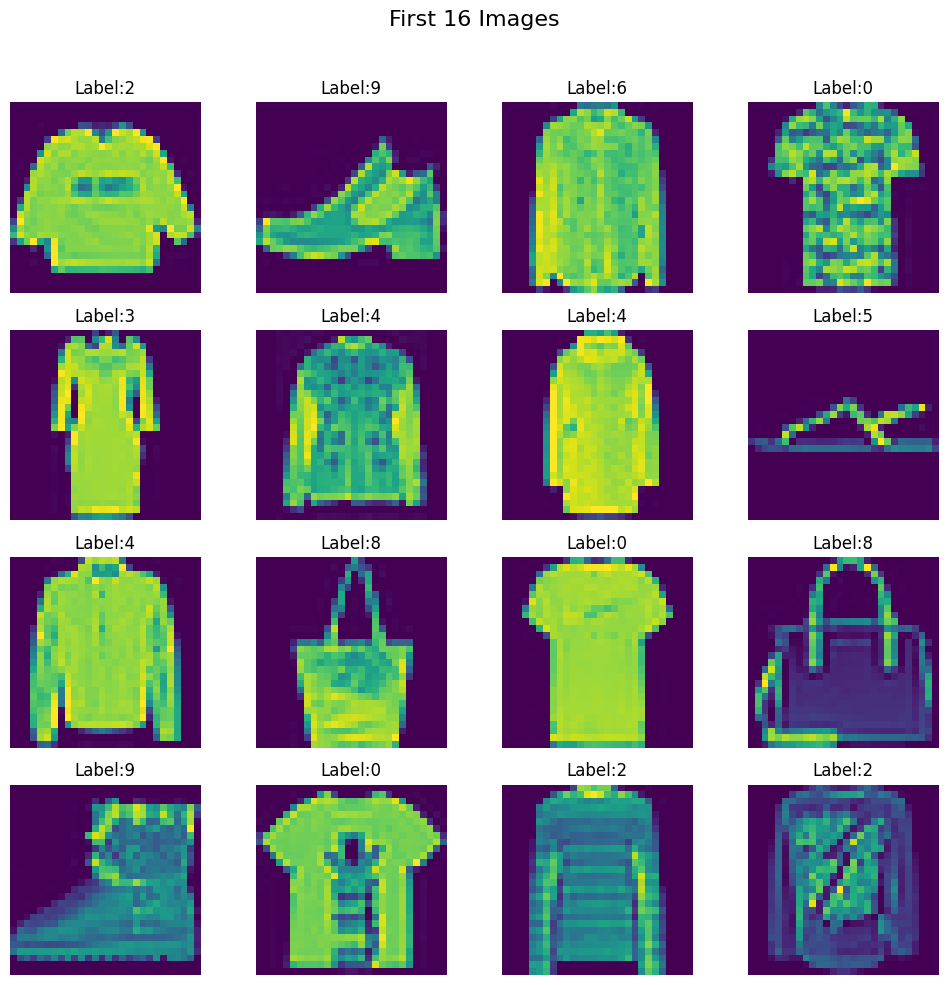

In [9]:
# Create a 4 x 4 grid of images
fig,axes = plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First 16 Images",fontsize =16)

# Plot the first 16 images
for i,ax in enumerate(axes.flat):
    img = df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img) # display in grayscale
    ax.axis('off') # remove axis for a cleaner look
    ax.set_title(f"Label:{df.iloc[i,0]}") # show the label
plt.tight_layout(rect=[0,0,1,0.96]) # adjust layout
plt.show()

In [10]:
# train test split
X=df.iloc[:,1:].values
y = df.iloc[:,0].values

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)

In [12]:
# transformation
from torchvision.transforms import transforms

# In the compose function we can add multiple transform
custom_transform = transforms.Compose(
    [
        transforms.Resize(256), # Used for Resize
        transforms.CenterCrop(224), # Used to crop 
        transforms.ToTensor(), # Convert it into Tensor str
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]) # Normalize the data
    ]
)

In [ ]:
from PIL import Image
import numpy as np

class CustomDataset(Dataset):
    def __init__(self,features,labels,transforms):
        self.features = features
        self.labels = labels
        self.transform = transforms
    
    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        # resize to (28,28)
        image = self.features[index].reshape(28,28)

        # change datatype to np.uint8
        image = image.astype(np.uint8)

        # change black&white to color
        image = np.stack([image]*3,axis=-1) # data we need in this format (H,W,C),and but after stack we got (C,H,W) , so we use axis=-1 to get in the same format

        # convert array to PIL image
        image= Image.fromarray(image)

        # Apply Transformation
        image = self.transform(image)

        return image,torch.tensor(self.labels[index],dtype=torch.long)

In [14]:
train_dataset = CustomDataset(X_train,y_train,transforms=custom_transform)


In [15]:
test_dataset = CustomDataset(X_test,y_test,transforms=custom_transform)

In [16]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32,shuffle=False,pin_memory=True)


In [30]:
# fetch the pretrained model
import torchvision.models as models
vgg16=models.vgg16(pretrained=True)

/home/dheeraj/Development/Pytorch Learning/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dheeraj/Development/Pytorch Learning/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [32]:
for param in vgg16.features.parameters():
    param.requires_grad=False
    

In [33]:
vgg16.classifier =nn.Sequential(
    nn.Linear(25088,1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    
    nn.Linear(512,10)
)

In [34]:
vgg16 = vgg16.to(device)

In [35]:
learning_rate = 0.0001
epochs = 10

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(),lr = learning_rate)

In [37]:
# training Loop
for epoch in range(epochs):
    total_epoch_loss = 0
    for batch_features, batch_labels in train_loader:
        # move data to gpu
        batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)
        
        # forward pass
        outputs = vgg16(batch_features)

        # calculate loss
        loss = criterion(outputs,batch_labels)
        # backpropogation
        optimizer.zero_grad()
        loss.backward()

        # update grads
        optimizer.step()

        # total loss
        total_epoch_loss = total_epoch_loss + loss.item()
    
    avg_loss = total_epoch_loss/len(train_loader)
    print(f'Epoch: {epoch+1},Loss: {avg_loss}')

Epoch: 1,Loss: 0.36503330618391433
Epoch: 2,Loss: 0.21672611196587482
Epoch: 3,Loss: 0.16730258505884557
Epoch: 4,Loss: 0.13167895209168395
Epoch: 5,Loss: 0.10459772118475909
Epoch: 6,Loss: 0.08339319510393155
Epoch: 7,Loss: 0.06925596833408053
Epoch: 8,Loss: 0.05519621487908686
Epoch: 9,Loss: 0.04736873179179141
Epoch: 10,Loss: 0.040716913546357925


In [38]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [39]:
# Evaluation on test data

total = 0
correct = 0

with torch.no_grad():
    for batch_features,batch_labels in test_loader:
        # move data to gpu
        batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)


        outputs = vgg16(batch_features)
        _,predicted = torch.max(outputs,1)
        total = total+batch_labels.shape[0]

        correct = correct+(predicted == batch_labels).sum().item()
print("Accuracy in test data: ",correct/total)


Accuracy in test data:  0.92975


In [40]:
# # evaluation code on training data
total = 0
correct = 0

with torch.no_grad():
    for batch_features,batch_labels in train_loader:
        # move data to gpu
        batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)


        outputs = vgg16(batch_features)
        _,predicted = torch.max(outputs,1)
        total = total+batch_labels.shape[0]

        correct = correct+(predicted == batch_labels).sum().item()
        
print("Accuracy in Train data: ",correct/total)

Accuracy in Train data:  0.9980416666666667
